<h1>Taxi Demand Prediction</h1>

http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml 

<h3> DATA DICTIONARY </h3>
<table>
<th>Field Name <th>Description
<tr> <td>VendorID <td>A code indicating the TPEP provider that provided the record.
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
<tr>
<td>tpep_pickup_datetime <td> The date and time when the meter was engaged.
<tr>
<td>tpep_dropoff_datetime <td>The date and time when the meter was disengaged.
<tr>
<td>Passenger_count <td>The number of passengers in the vehicle.
This is a driver-entered value.
<tr>
<td>Trip_distance <td>The elapsed trip distance in miles reported by the taximeter.
<tr>
<td>PULocationID <td>TLC Taxi Zone in which the taximeter was engaged
<tr><td>DOLocationID <td>TLC Taxi Zone in which the taximeter was disengaged
<tr><td>RateCodeID <td>The final rate code in effect at the end of the trip.
1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride
<tr>
<td>Store_and_fwd_flag <td>This flag indicates whether the trip record was held in vehicle
memory before sending to the vendor, aka “store and forward,”
because the vehicle did not have a connection to the server.
Y= store and forward trip
N= not a store and forward trip
<tr>
<td>Payment_type <td>A numeric code signifying how the passenger paid for the trip.
1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip
<tr><td>
Fare_amount <td>The time-and-distance fare calculated by the meter.
<tr><td>
Extra <td>Miscellaneous extras and surcharges. Currently, this only includes
the $0.50 and $1 rush hour and overnight charges.
<tr><td>
MTA_tax <td>$0.50 MTA tax that is automatically triggered based on the metered
rate in use.
<tr><td>
Improvement_surcharge <td>$0.30 improvement surcharge assessed trips at the flag drop. The
improvement surcharge began being levied in 2021.
<tr><td>
Tip_amount <td>Tip amount – This field is automatically populated for credit card
tips. Cash tips are not included.
<tr><td>
Tolls_amount <td>Total amount of all tolls paid in trip.
<tr><td>
Total_amount <td>The total amount charged to passengers. Does not include cash tips.
<tr><td>
Congestion_Surcharge <td>Total amount collected in trip for NYS congestion surcharge.
<tr><td>
Airport_fee <td>$1.25 for pick up only at LaGuardia and John F. Kennedy Airports
</table>

In [2]:
#Importing the required libraries
import pandas as pd
import numpy as np
import pyarrow
import fastparquet
#import folium
import datetime
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
from math import ceil, floor
import pickle
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from numpy.ma import count
from numpy.core.umath import log

In [3]:
jan2021 = pd.read_parquet("C:yellow_tripdata_2021-01.parquet")

In [4]:
jan2021.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [5]:
jan2021.shape

(1369769, 19)

In [6]:
pd.value_counts(jan2021.dtypes)

float64           12
int64              4
datetime64[ns]     2
object             1
dtype: int64

In [7]:
jan2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1369769 entries, 0 to 1369768
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1369769 non-null  int64         
 1   tpep_pickup_datetime   1369769 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1369769 non-null  datetime64[ns]
 3   passenger_count        1271417 non-null  float64       
 4   trip_distance          1369769 non-null  float64       
 5   RatecodeID             1271417 non-null  float64       
 6   store_and_fwd_flag     1271417 non-null  object        
 7   PULocationID           1369769 non-null  int64         
 8   DOLocationID           1369769 non-null  int64         
 9   payment_type           1369769 non-null  int64         
 10  fare_amount            1369769 non-null  float64       
 11  extra                  1369769 non-null  float64       
 12  mta_tax                13697

In [8]:
jan2021.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,1.369769e+06,1.271417e+06,1.369769e+06,1.271417e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.369769e+06,1.271417e+06,5.0
mean,1.721725e+00,1.411508e+00,4.631983e+00,1.035081e+00,1.652474e+02,1.614957e+02,1.188578e+00,1.209663e+01,9.705133e-01,4.930412e-01,1.918098e+00,2.477473e-01,2.969412e-01,1.747440e+01,2.239047e+00,0.0
std,5.925347e-01,1.059831e+00,3.939037e+02,5.994830e-01,6.783854e+01,7.210795e+01,5.776546e-01,1.291337e+01,1.231258e+00,7.632059e-02,2.597151e+00,1.672761e+00,4.222168e-02,1.469342e+01,7.989435e-01,0.0
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-4.900000e+02,-5.500000e+00,-5.000000e-01,-1.000000e+02,-3.112000e+01,-3.000000e-01,-4.928000e+02,-2.500000e+00,0.0
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.240000e+02,1.070000e+02,1.000000e+00,6.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.080000e+01,2.500000e+00,0.0
50%,2.000000e+00,1.000000e+00,1.700000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,8.500000e+00,0.000000e+00,5.000000e-01,1.860000e+00,0.000000e+00,3.000000e-01,1.380000e+01,2.500000e+00,0.0
75%,2.000000e+00,1.000000e+00,3.020000e+00,1.000000e+00,2.360000e+02,2.360000e+02,1.000000e+00,1.350000e+01,2.500000e+00,5.000000e-01,2.750000e+00,0.000000e+00,3.000000e-01,1.912000e+01,2.500000e+00,0.0
max,6.000000e+00,8.000000e+00,2.631633e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,6.960500e+03,8.250000e+00,5.000000e-01,1.140440e+03,8.117500e+02,3.000000e-01,7.661280e+03,3.000000e+00,0.0


## Preparing the data

### Handling Null Values

In [9]:
jan2021.isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            98352
trip_distance                  0
RatecodeID                 98352
store_and_fwd_flag         98352
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge       98352
airport_fee              1369764
dtype: int64

In [10]:
def null_value_handled(df):
    df['airport_fee']= df['airport_fee'].fillna(0)
    df.loc[df['airport_fee'].isnull()]
    df['congestion_surcharge']= df['congestion_surcharge'].fillna(df['total_amount']-(df['fare_amount']+df['extra']+df['mta_tax']+df['tip_amount']+df['tolls_amount']+df['improvement_surcharge']))
    df=df.drop('store_and_fwd_flag',axis=1)
    average=df['total_amount']/df['trip_distance']
    mean=np.mean(average[np.isfinite(average)])
    df['passenger_count']= df['passenger_count'].fillna(0)
    df['RatecodeID']= df['RatecodeID'].fillna(0)
    return(df)

In [11]:
jan2021 = null_value_handled(jan2021)

In [12]:
jan2021.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

## Cleaning the data

Finding outliers based on quartiles and percentiles, also need to remove error values. We will proceed feature by feature

## Finding trip durations

In [13]:
def convert_to_unix(s):
    return (s- np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')

In [70]:
def calc_trip_times(df):

    duration = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]
# pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
# calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    # append durations of trips and speed in miles/hr to a new dataframe
    new_frame = df[['passenger_count', 'trip_distance', 'PULocationID','DOLocationID','total_amount']].copy()
    new_frame['trip_time'] = durations
    new_frame['pickup_times']= duration_pickup
    new_frame['Speed'] = 60 *(new_frame['trip_distance']/new_frame['trip_time'])
    
    return new_frame

In [71]:
jan2021_with_durations = calc_trip_times(jan2021)

In [72]:
jan2021_with_durations.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_time,pickup_times,Speed
0,1.0,2.10,142,43,11.80,6.033333,1.609461e+09,20.883978
1,1.0,0.20,238,151,4.30,0.983333,1.609462e+09,12.203390
2,1.0,14.70,132,165,51.95,27.600000,1.609462e+09,31.956522
3,0.0,10.60,138,132,36.35,15.216667,1.609460e+09,41.796276
4,1.0,4.94,68,33,24.36,16.533333,1.609461e+09,17.927419


## Trip Duration

In [73]:
for i in range(0,100,10):
    var =jan2021_with_durations["trip_time"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -135084.63333333333
10 percentile value is 3.5166666666666666
20 percentile value is 4.933333333333334
30 percentile value is 6.216666666666667
40 percentile value is 7.566666666666666
50 percentile value is 9.066666666666666
60 percentile value is 10.866666666666667
70 percentile value is 13.133333333333333
80 percentile value is 16.45
90 percentile value is 22.866666666666667
100 percentile value is  28817.7


In [74]:
#removing data based on our analysis and TLC regulations
jan2021_with_durations=jan2021_with_durations[(jan2021_with_durations.trip_time>1) & (jan2021_with_durations.trip_time<720)]

In [75]:
for i in range(0,100,10):
    var =jan2021_with_durations["trip_time"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 1.0166666666666666
10 percentile value is 3.7333333333333334
20 percentile value is 5.066666666666666
30 percentile value is 6.333333333333333
40 percentile value is 7.683333333333334
50 percentile value is 9.183333333333334
60 percentile value is 10.966666666666667
70 percentile value is 13.233333333333333
80 percentile value is 16.533333333333335
90 percentile value is 22.866666666666667
100 percentile value is  718.3166666666667


In [76]:
len(jan2021_with_durations)

1346877

## Trip Distance

In [77]:
for i in range(0,100,10):
    var =jan2021_with_durations["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.13
40 percentile value is 1.4
50 percentile value is 1.7
60 percentile value is 2.1
70 percentile value is 2.63
80 percentile value is 3.6
90 percentile value is 6.3
100 percentile value is  263163.28


In [78]:
#Can trip distance be zero?

In [79]:
#The end value seem too high

In [80]:
for i in range(90,100):
    var =jan2021_with_durations["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 6.3
91 percentile value is 6.86
92 percentile value is 7.52
93 percentile value is 8.3
94 percentile value is 9.2
95 percentile value is 10.3
96 percentile value is 11.77
97 percentile value is 13.91
98 percentile value is 17.0
99 percentile value is 19.26
100 percentile value is  263163.28


In [81]:
for i in np.arange(0.0, 1.0, 0.1):
    var =jan2021_with_durations["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 19.26
99.1 percentile value is 19.52
99.2 percentile value is 19.86
99.3 percentile value is 20.21
99.4 percentile value is 20.64
99.5 percentile value is 21.16
99.6 percentile value is 21.85
99.7 percentile value is 22.94
99.8 percentile value is 25.04
99.9 percentile value is 28.82
100 percentile value is  263163.28


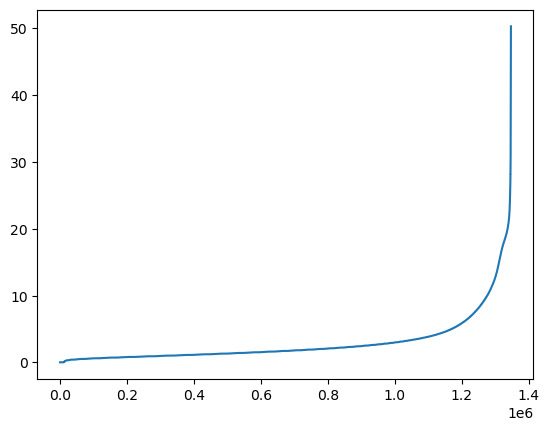

In [82]:
plt.plot(var[:-150])
plt.show()

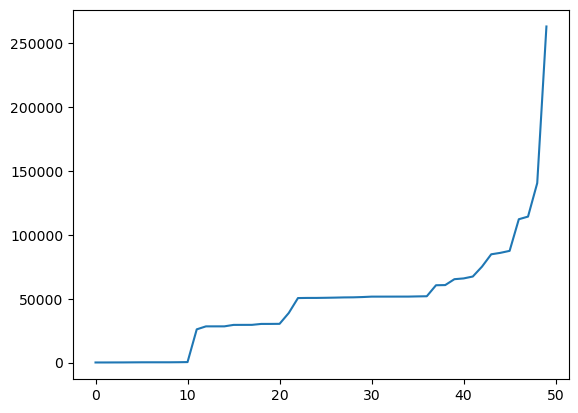

In [83]:
# a very sharp increase in distance values can be seen 
# plotting last three total distance values, and we can observe there is sharp increase in the values
plt.plot(var[-50:])
plt.show()

In [84]:
jan2021_with_durations[jan2021_with_durations['trip_distance'] > 29]

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,trip_time,pickup_times,Speed
298,1.0,33.18,91,240,96.67,42.866667,1.609462e+09,46.441680
770,1.0,32.58,234,48,114.42,93.200000,1.609459e+09,20.974249
3705,4.0,33.80,132,265,128.42,43.666667,1.609476e+09,46.442748
4292,1.0,33.09,132,265,137.76,38.850000,1.609482e+09,51.104247
5474,1.0,38.26,135,44,108.67,43.700000,1.609493e+09,52.530892
...,...,...,...,...,...,...,...,...
1368584,0.0,31.43,70,5,104.00,76.000000,1.612097e+09,24.813158
1369180,0.0,32.75,166,156,104.00,39.000000,1.612110e+09,50.384615
1369297,0.0,32.95,156,166,93.50,56.000000,1.612114e+09,35.303571
1369488,0.0,39.07,23,81,120.50,74.583333,1.612121e+09,31.430615


## For total amount

In [85]:
for i in range(0,100,10):
    var =jan2021_with_durations["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -225.3
10 percentile value is 8.8
20 percentile value is 10.3
30 percentile value is 11.3
40 percentile value is 12.36
50 percentile value is 13.8
60 percentile value is 15.36
70 percentile value is 17.75
80 percentile value is 21.3
90 percentile value is 29.75
100 percentile value is  7661.28


In [86]:
#Amount can not be negative 

In [87]:
for i in range(90,100):
    var =jan2021_with_durations["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 29.75
91 percentile value is 31.31
92 percentile value is 33.35
93 percentile value is 35.8
94 percentile value is 38.6
95 percentile value is 41.8
96 percentile value is 45.92
97 percentile value is 51.3
98 percentile value is 58.92
99 percentile value is 69.12
100 percentile value is  7661.28


In [88]:
for i in np.arange(0.0, 1.0, 0.1):
    var =jan2021_with_durations["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print ("100 percentile value is ",var[-1])

99.0 percentile value is 69.12
99.1 percentile value is 70.7
99.2 percentile value is 71.42
99.3 percentile value is 73.65
99.4 percentile value is 73.7
99.5 percentile value is 73.92
99.6 percentile value is 76.77
99.7 percentile value is 79.55
99.8 percentile value is 86.0
99.9 percentile value is 102.06
100 percentile value is  7661.28


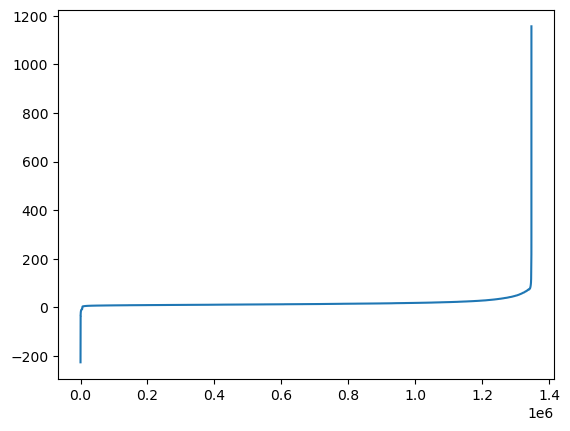

In [89]:
plt.plot(var[:-2])
plt.show()

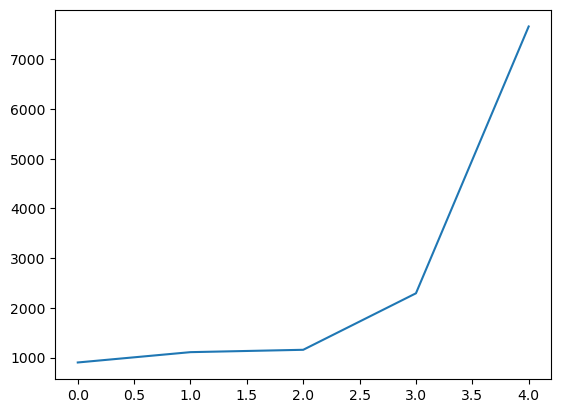

In [90]:
plt.plot(var[-5:])
plt.show()

In [91]:
var[-5]

900.35

## Speed

In [93]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =jan2021_with_durations["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 7.698795180722891
20 percentile value is 9.028571428571428
30 percentile value is 10.018552875695734
40 percentile value is 10.919431279620854
50 percentile value is 11.851851851851853
60 percentile value is 12.921535893155259
70 percentile value is 14.320441988950275
80 percentile value is 16.46066134549601
90 percentile value is 20.978417266187048
100 percentile value is  1054121.8499999999


In [95]:
#calculating speed values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var =jan2021_with_durations["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.978417266187048
91 percentile value is 21.765517241379307
92 percentile value is 22.68
93 percentile value is 23.725622057834567
94 percentile value is 24.932038834951452
95 percentile value is 26.362545018007204
96 percentile value is 28.18251786695987
97 percentile value is 30.49877750611247
98 percentile value is 33.451152579582875
99 percentile value is 37.734375
100 percentile value is  1054121.8499999999


In [99]:
for i in np.arange(0.0, 1.0, 0.1):
    var =jan2021_with_durations["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print ("100 percentile value is ",var[-1])

99.0 percentile value is 37.734375
99.1 percentile value is 38.28141783029001
99.2 percentile value is 38.918181818181814
99.3 percentile value is 39.603960396039604
99.4 percentile value is 40.373831775700936
99.5 percentile value is 41.20600272851296
99.6 percentile value is 42.20307692307693
99.7 percentile value is 43.446205170975816
99.8 percentile value is 45.048913043478265
99.9 percentile value is 47.60454545454545
100 percentile value is  1054121.8499999999


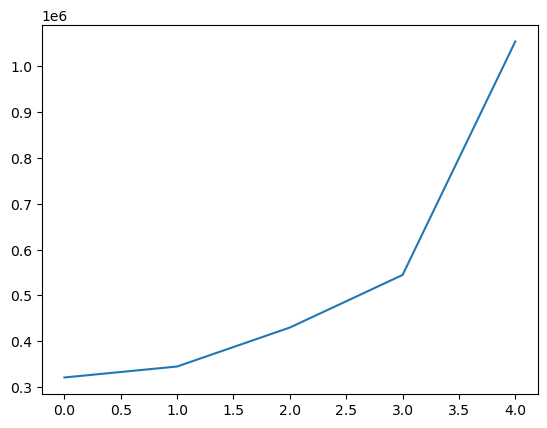

In [97]:
plt.plot(var[-5:])
plt.show()

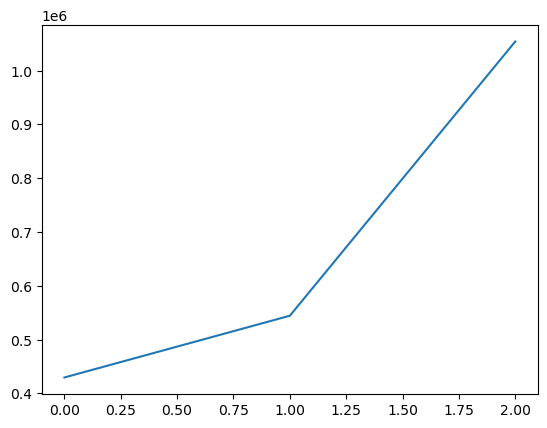

In [98]:
plt.plot(var[-3:])
plt.show()

In [103]:
#Final function including speed
#removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    
    temp_frame = new_frame[(new_frame.trip_time > 0) & (new_frame.trip_time < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 29)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    new_frame = new_frame[(new_frame.trip_time > 0) & (new_frame.trip_time < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 46.285714285714285) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed "+ str(a - new_frame.shape[0]))
    print ("---")
    return new_frame

In [104]:
avgSpeed = jan2021_with_durations['Speed'].sum()/len(jan2021_with_durations)
print(avgSpeed)

18.9064012916534
